In [10]:
import os
import pickle
import sys
import pygam
import numpy as np
import allensdk.core.json_utilities as ju
from mcmodels.core import Mask
from mcmodels.utils import nonzero_unique
import matplotlib as mpl
from pylab import rcParams
from mpl_toolkits.mplot3d import proj3d
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}'] #for \text command
import matplotlib.pyplot as plt

workingdirectory = os.popen("git rev-parse --show-toplevel").read()[:-1]
sys.path.append(workingdirectory)
os.chdir(workingdirectory)
from mcmodels.core import VoxelModelCache
from mcmodels.core.connectivity_data import get_connectivity_data
import pandas as pd


path = "analyses/results/EL_model_projnorm_cutoffremoved_060622_leafleaf.pickle"
with open(
    path, "rb"
) as handle:
    twostage_leaf_creleaf2 = pickle.load(handle)

with open("data/meta/leafs.pickle", "rb") as handle:
    leafs = pickle.load(handle)
    
TOP_DIR = workingdirectory
INPUT_JSON = workingdirectory + "/data/meta/input_011520.json"
FOLDER = workingdirectory + "/data/raw/"
EXPERIMENTS_EXCLUDE_JSON = workingdirectory + "/data/meta/experiments_exclude.json"
COARSE_STRUCTURE_SET_ID = 2
DEFAULT_STRUCTURE_SET_IDS = tuple([COARSE_STRUCTURE_SET_ID])

data_info = pd.read_excel(
    workingdirectory + "/data/meta/Whole Brain Cre Image Series_curation only.xlsx",
    "all datasets curated_070919pull",
)
data_info.set_index("id", inplace=True)
input_data = ju.read(INPUT_JSON)
manifest_file = input_data.get("manifest_file")
manifest_file = os.path.join(TOP_DIR, manifest_file)
cache = VoxelModelCache(manifest_file=manifest_file)
st = cache.get_structure_tree()
ai_map = st.get_id_acronym_map()
ia_map = {value: key for key, value in ai_map.items()}
experiments_exclude = ju.read(EXPERIMENTS_EXCLUDE_JSON)
major_structure_ids = np.load(workingdirectory + "/data/meta/major_structure_ids.npy")
ontological_order = np.load("data/meta/ontological_order_v3.npy")
ontological_order_leaves = np.load(
    workingdirectory + "/data/meta/ontological_order_leaves_v3.npy"
)
connectivity_data = get_connectivity_data(
    cache,
    major_structure_ids,
    experiments_exclude,
    remove_injection=False,
    structure_set_id=167587189,
    folder=FOLDER,
)

connectivity_data.get_crelines(data_info)
crelines = {sid: connectivity_data.creline[sid] for sid in major_structure_ids}
sid0 = list(connectivity_data.structure_datas.keys())[0]
eid0 = list(connectivity_data.structure_datas[sid0].experiment_datas.keys())[0]
default_structures = st.get_structures_by_set_id(DEFAULT_STRUCTURE_SET_IDS)
default_structure_ids = [st["id"] for st in default_structures if st["id"] != 934]
connectivity_data.get_injection_hemisphere_ids()
connectivity_data.align()
connectivity_data.get_centroids()
connectivity_data.get_data_matrices(default_structure_ids)

annotation/ccf_2017
512
703
1089
1097
315
313
354
698
771
803
477
549


In [14]:
contra_targetkey = connectivity_data.structure_datas[sid0].projection_mask.get_key(
    structure_ids=ontological_order_leaves, hemisphere_id=1
)
ipsi_targetkey = connectivity_data.structure_datas[sid0].projection_mask.get_key(
    structure_ids=ontological_order_leaves, hemisphere_id=2
)
connectivity_data.get_regionalized_normalized_data(
    ontological_order, ipsi_targetkey, contra_targetkey
)


In [15]:
above_thresh = {}
thresh = 1
for m in range(12):
    sid = major_structure_ids[m]
    above_thresh[sid] = np.where(
        connectivity_data.structure_datas[sid].reg_inj.sum(axis=1) > thresh
    )[0]

In [16]:
crelines = {sid: connectivity_data.creline[sid][above_thresh[sid]] for sid in major_structure_ids}
with open("data/meta/leafs.pickle", "rb") as handle:
    leafs = pickle.load(handle)
leafs = {sid: leafs[sid][above_thresh[sid]] for sid in major_structure_ids}

In [17]:
creleafs = {}
creleafs_merged = {}

major_structure_ids = np.asarray(list(connectivity_data.structure_datas.keys()))
for sid in major_structure_ids:
    creleafs[sid] = np.asarray(np.vstack([leafs[sid], crelines[sid]]), dtype=str).transpose()
    creleafs_merged[sid] = [creleafs[sid][:, 0][i] + creleafs[sid][:, 1][i] for i in range(creleafs[sid].shape[0])]
    creleafs_merged[sid] = np.asarray(creleafs_merged[sid])

In [18]:
from mcmodels.core.utils import (
    get_indices_2ormore, get_eval_indices)
creleaf2_index_matrices = get_indices_2ormore(creleafs_merged)
creleaf2_evalindices = get_eval_indices(creleaf2_index_matrices)

In [55]:
from tqdm import tqdm

def get_comboloss(self, structures,crelines,ia_map):

    eval_indices = self.eval_indices
    losses = self.losses
    gammas = self.gammas
    models = self.models
    ngamma = len(gammas)
    nmodels = len(models)
    nw_losses_all = np.zeros((ngamma, nmodels))
    save_losses = []
    gammas = np.asarray([0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000])
    
    for m, sid in tqdm(enumerate(models)):
        print(sid)
        g = np.where(gammas == self.bestgamma_weighted[m])[0]

        leaf_sid = np.asarray([ia_map[structures[sid][i]] for i in range(len(structures[sid]))])[eval_indices[sid]]
        comboloss_np = np.asarray([losses[sid][g, :][0],crelines[sid][eval_indices[sid]],leaf_sid, np.repeat(sid, len(leaf_sid))])
        comboloss = pd.DataFrame(comboloss_np).transpose()

        comboloss.columns = np.asarray(['Loss', 'Creline', 'Leaf', 'Structure'])

        #        comboloss['EL-Sum-Loss'] = pd.to_numeric(comboloss['EL-Sum-Loss'])
        comboloss['Loss'] = pd.to_numeric(comboloss['Loss'])
        a = comboloss.pivot_table(values='Loss',index='Leaf',columns='Creline',aggfunc=np.mean)
        loss_mean = a.stack().to_frame()
        save_losses.append(loss_mean)
    return save_losses


In [56]:
self = twostage_leaf_creleaf2
structures = leafs

In [58]:
losses = get_comboloss(twostage_leaf_creleaf2, leafs, crelines, ia_map)
losses_combined = pd.concat(losses)

12it [00:00, 100.29it/s]

512
703
1089
1097
315
313
354
698
771
803
477
549


In [29]:
abundances = []
ontological_order_leaves = np.load(workingdirectory + '/data/meta/ontological_order_leaves_v3.npy')
for m, sid in enumerate(major_structure_ids):
    source_mask = Mask.from_cache(cache, structure_ids=[sid], hemisphere_id=2)
    source_key = source_mask.get_key(structure_ids=ontological_order_leaves)
    source_regions, source_counts = nonzero_unique(source_key, return_counts=True)
    nexp = connectivity_data.creline[sid].shape[0]
    ls = [ia_map[leafs[sid][i]] for i in range(len(leafs[sid]))]
    crs = crelines[sid]
    df = pd.DataFrame(np.asarray([ls, crs, np.ones(len(ls))]).transpose())
    df.columns = np.asarray(['Leaf', 'Creline','present'])
    a = df.pivot_table(values='present',index='Leaf',columns='Creline',aggfunc=np.sum)
    abundance = a.stack().to_frame()
    abundance['Structure'] = sid
    abundance= abundance[abundance[0] > 1]
    abundances.append(abundance)

In [31]:
abundances_combined =  pd.concat(abundances)

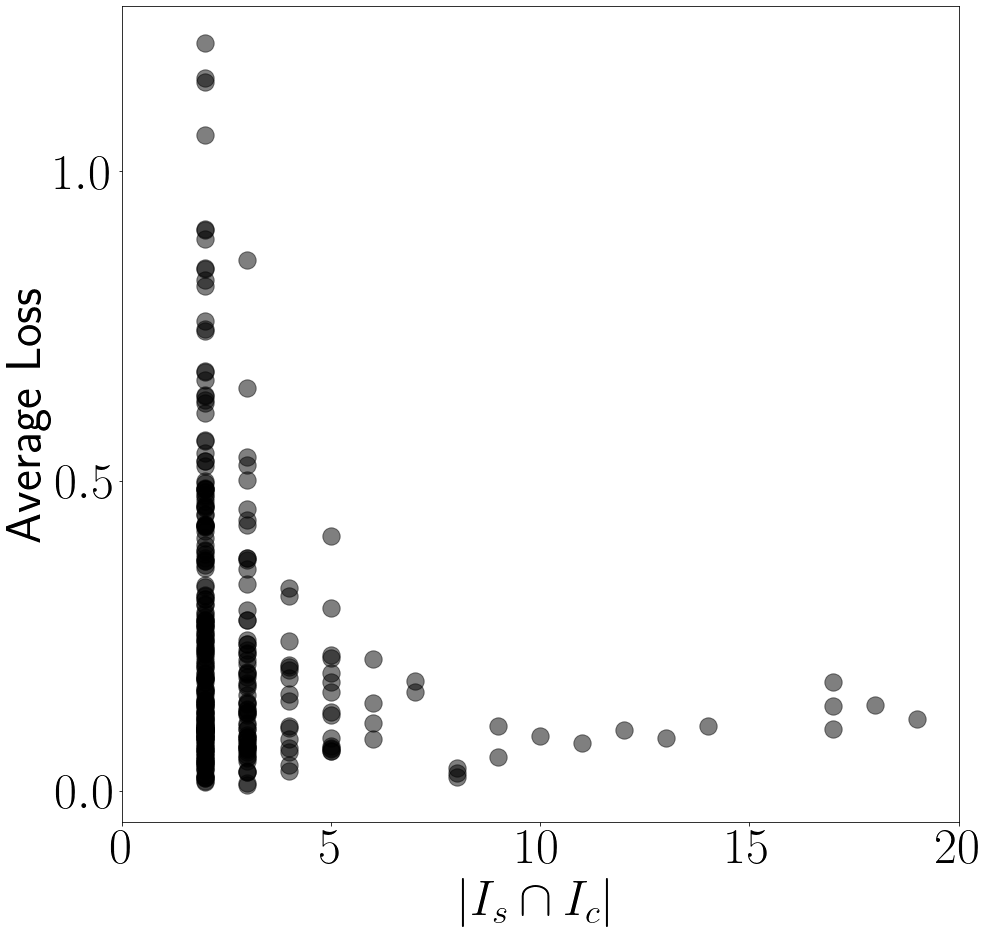

In [111]:
%matplotlib inline

fig, ax= plt.subplots(1,1, figsize =(15,15))
ax.scatter(abundances_combined[0], losses_combined[0], s = 300, alpha = .5, c = 'black')
ax.set_xticks([0,5,10,15,20])
ax.set_yticks([0,.5,1.])
[tick.label.set_fontsize(50) for tick in ax.xaxis.get_major_ticks()]
[tick.label.set_fontsize(50) for tick in ax.yaxis.get_major_ticks()]
ax.set_xlabel(r'$|I_s \cap I_c|$', fontsize= 50)
ax.set_ylabel(r'Average Loss', fontsize = 50)
plt.savefig(f'{workingdirectory}/paper/KoelleConn_revision/figs/losssummary')